In [1]:
import os
import torch
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline
from PIL import Image
from create_latent_classifier import LatentClassifierT

device = "cuda" if torch.cuda.is_available() else "cpu"

/share/u/kevin/miniconda3/envs/asdf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
def guided_generation_latent(pipe, prompt, classifier, target_class_prob=1.0, num_inference_steps=50, guidance_scale=7.5, classifier_scale=10.0, seed=42, t_downsample=64, eta = 1.0, variance_scale = None):
    """
    Using classifier guidance during the inference pipeline
    """

    generator = torch.Generator(device=device).manual_seed(seed)

    # --- text embeddings ---
    text_inputs = pipe.tokenizer(
        prompt, return_tensors="pt", padding="max_length", truncation=True,
        max_length=pipe.tokenizer.model_max_length
    )
    text_emb = pipe.text_encoder(text_inputs.input_ids.to(device))[0]
    uncond_emb = pipe.text_encoder(
        pipe.tokenizer([""], return_tensors="pt", padding="max_length",
                       max_length=pipe.tokenizer.model_max_length).input_ids.to(device)
    )[0]
    text_emb = torch.cat([uncond_emb, text_emb])

    # --- initial latents ---
    latents = torch.randn((1, pipe.unet.in_channels, 64, 64),
                          generator=generator, device=device, dtype=torch.float16)
    latents = latents * pipe.scheduler.init_noise_sigma
    pipe.scheduler.set_timesteps(num_inference_steps)

    # --- diffusion loop ---
    for i, t in enumerate(pipe.scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_emb).sample

        # Classifier-free guidance
        noise_uncond, noise_text = noise_pred.chunk(2)
        noise_pred = noise_uncond + guidance_scale * (noise_text - noise_uncond)

        latents.requires_grad_(True)
        with torch.enable_grad():
            latents_down = latents.float()

            logit = classifier(latents_down, t.expand(latents.size(0)).to(latents.device))
            target = torch.tensor(target_class_prob, device=device)
            loss = F.binary_cross_entropy_with_logits(logit.squeeze(), target)
            grad = torch.autograd.grad(-loss, latents)[0]

        grad_scaled = grad * classifier_scale
        alpha_prod_t = pipe.scheduler.alphas_cumprod[t]
        beta_prod_t = 1- alpha_prod_t
        noise_pred = noise_pred - beta_prod_t.sqrt() * grad_scaled

        latents = pipe.scheduler.step(noise_pred, t, latents, eta=eta).prev_sample

    with torch.no_grad():
        image = pipe.vae.decode(latents / 0.18215).sample


    image = (image / 2 + 0.5).clamp(0, 1)
    image = (image.cpu().permute(0, 2, 3, 1).numpy()[0] * 255).astype("uint8")
    return Image.fromarray(image)


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


✅ Loaded latent classifier for 'golf ball' (epoch 3)

Prompt:  | Classifier scale: 20
  η=1.00, variance_scale=1.00


/tmp/ipykernel_2917534/2146849717.py:21: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64),


  η=1.17, variance_scale=1.00
  η=1.34, variance_scale=1.00
  η=1.51, variance_scale=1.00
  η=1.68, variance_scale=1.00
  η=1.85, variance_scale=1.00

Prompt:  | Classifier scale: 50
  η=1.00, variance_scale=1.00
  η=1.17, variance_scale=1.00
  η=1.34, variance_scale=1.00
  η=1.51, variance_scale=1.00
  η=1.68, variance_scale=1.00
  η=1.85, variance_scale=1.00

Prompt:  | Classifier scale: 100
  η=1.00, variance_scale=1.00
  η=1.17, variance_scale=1.00
  η=1.34, variance_scale=1.00
  η=1.51, variance_scale=1.00
  η=1.68, variance_scale=1.00
  η=1.85, variance_scale=1.00

Prompt:  | Classifier scale: 200
  η=1.00, variance_scale=1.00
  η=1.17, variance_scale=1.00
  η=1.34, variance_scale=1.00
  η=1.51, variance_scale=1.00
  η=1.68, variance_scale=1.00
  η=1.85, variance_scale=1.00


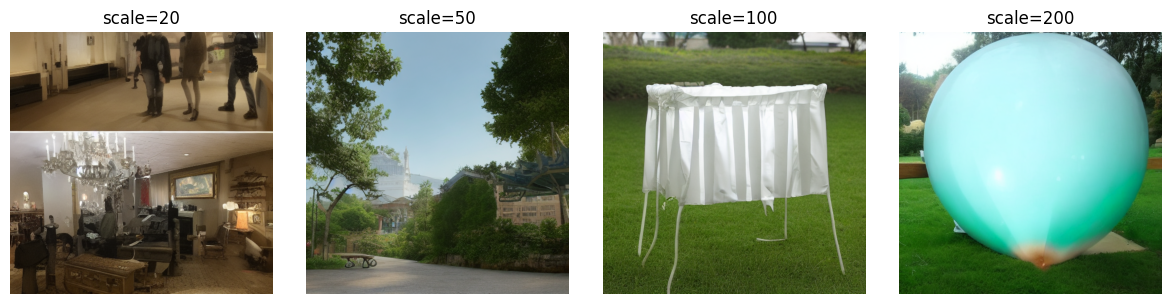

In [ ]:
import torch, os
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from create_latent_classifier import LatentClassifierT
from noisy_diffuser_scheduling.schedulers.eta_ddim_scheduler import DDIMScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load Stable Diffusion ---
model_path = "/share/u/kevin/ErasingDiffusionModels/final_models/esdx_golf_ball"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to(device)
pipe.safety_checker = None
pipe.scheduler = DDIMScheduler.from_pretrained(model_path, subfolder="scheduler", torch_dtype=torch.float16)
# --- Load classifier ---
classifier_path = "/share/u/kevin/DiffusionConceptErasure/classifier_guidance/latent_classifiers/golf_ball.pt"
classifier = LatentClassifierT(scheduler=pipe.scheduler).to(device)
checkpoint = torch.load(classifier_path, map_location=device)
classifier.load_state_dict(checkpoint["model_state_dict"])
classifier.eval()
print(f"✅ Loaded latent classifier for 'golf ball' (epoch {checkpoint.get('epoch', '?')})")

# --- Prompts and scales ---
prompts = [
    "",
    # "golf ball",
]
scales = [50, 100, 150, 200]
etas = [1.0, 1.17, 1.34, 1.51, 1.68, 1.85]
variance_scales=[1.0]
# --- Generate images ---
results = {}  # dict[(prompt, scale)] -> list of images
for prompt in prompts:
    for scale in scales:
        imgs = []
        print(f"\nPrompt: {prompt} | Classifier scale: {scale}")
        for eta in etas:
            for variance_scale in variance_scales:
                print(f"  η={eta:.2f}, variance_scale={variance_scale:.2f}")
                img = guided_generation_latent(
                    pipe, prompt, classifier,
                    target_class_prob=1.0,
                    num_inference_steps=50,
                    guidance_scale=7.5,
                    classifier_scale=scale,
                    eta=eta,
                    # variance_scale=variance_scale,
                )
                imgs.append(img)
        results[(prompt, scale)] = imgs

# --- Plot a summary grid (first image for each config) ---
n_rows, n_cols = len(prompts), len(scales)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

for i, prompt in enumerate(prompts):
    for j, scale in enumerate(scales):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        first_img = results[(prompt, scale)][0]  # pick first η/variance combo
        ax.imshow(first_img)
        ax.axis("off")
        if i == 0:
            ax.set_title(f"scale={scale}", fontsize=12)
        if j == 0:
            ax.set_ylabel(prompt, fontsize=11, rotation=0, labelpad=90, va="center")

plt.tight_layout()
plt.show()


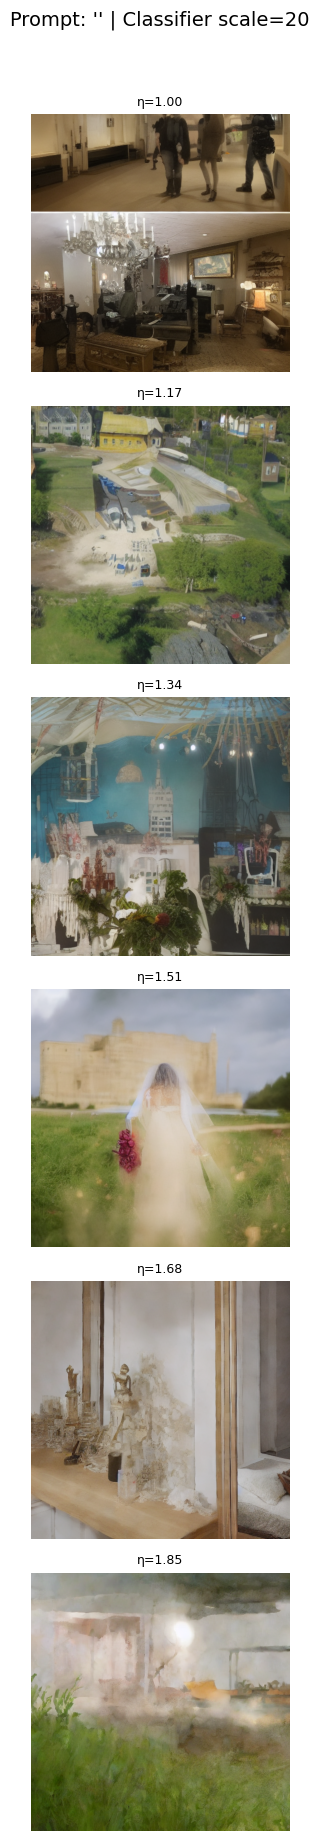

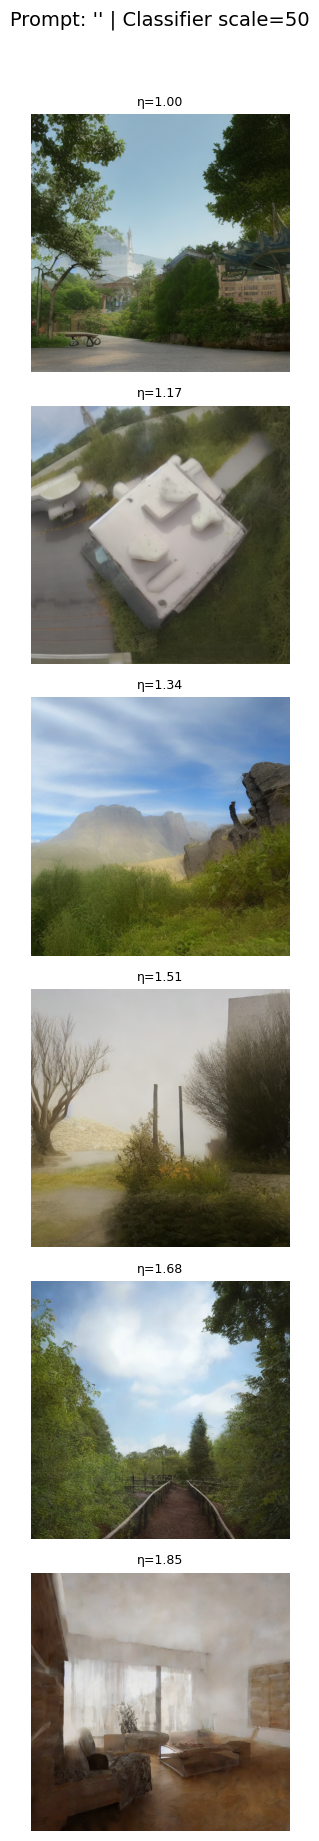

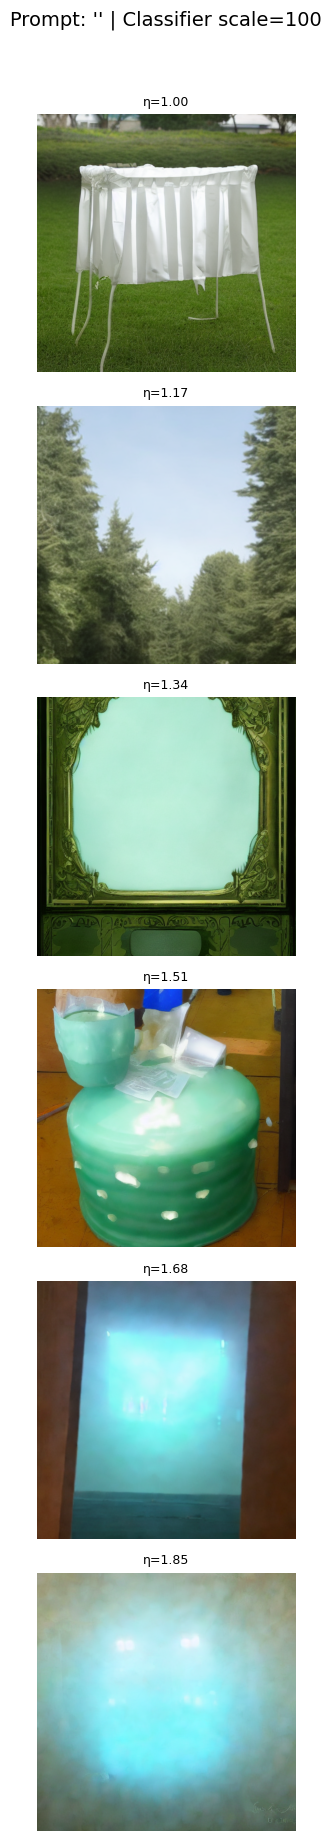

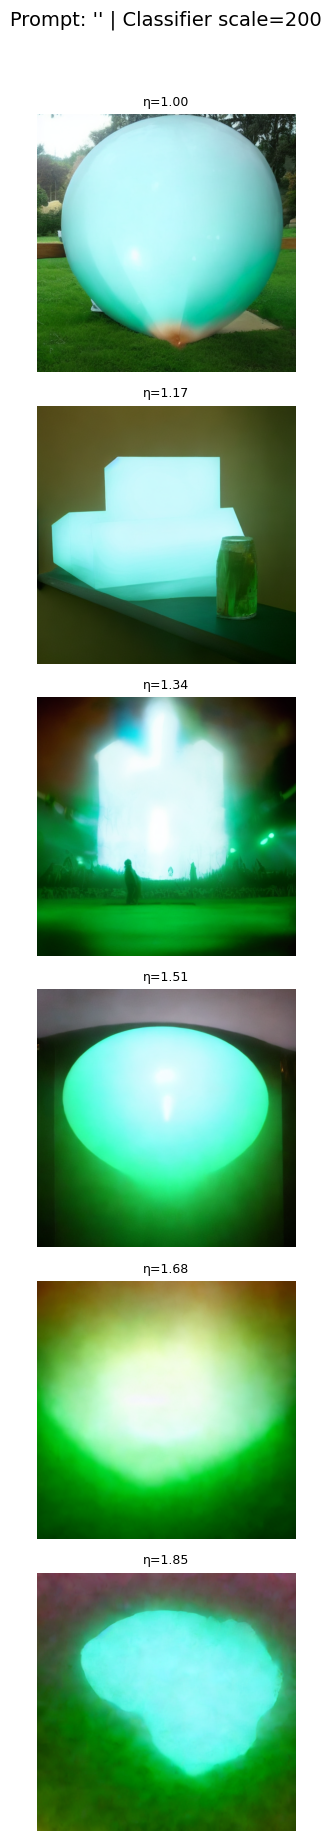

In [62]:

for prompt in prompts:
    for scale in scales:
        imgs = results[(prompt, scale)]
        n_rows = len(etas)
        n_cols = len(variance_scales)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
        fig.suptitle(f"Prompt: '{prompt}' | Classifier scale={scale}", fontsize=14, y=1.02)

        # Flattened list → reshape by (eta_idx, var_idx)
        idx = 0
        for i, eta in enumerate(etas):
            ax = axes[i]
            ax.imshow(imgs[idx])
            ax.axis("off")
            ax.set_title(f"η={eta:.2f}", fontsize=9)
            idx += 1

        plt.tight_layout()
        plt.show()

In [ ]:
import torch, os
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from create_latent_classifier import LatentClassifierT
from noisy_diffuser_scheduling.schedulers.eta_ddim_scheduler import DDIMScheduler
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load Stable Diffusion ---
model_path = "/share/u/kevin/ErasingDiffusionModels/final_models/esdx_golf_ball"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to(device)
pipe.safety_checker = None

# --- Load classifier ---
classifier_path = "/share/u/kevin/DiffusionConceptErasure/classifier_guidance/latent_classifiers/golf_ball.pt"
classifier = LatentClassifierT(scheduler=pipe.scheduler).to(device)
checkpoint = torch.load(classifier_path, map_location=device)
classifier.load_state_dict(checkpoint["model_state_dict"])
classifier.eval()
print(f"✅ Loaded latent classifier for 'golf ball' (epoch {checkpoint.get('epoch', '?')})")

# --- Prompts and scales ---
prompts = [
    "a picture of a golf ball",
    "golf ball",
    ""
]
scales = [0, 40]
etas = [1.0, 1.17, 1.34, 1.51, 1.68, 1.85]
variance_scales = [1.0, 1.02, 1.03, 1.04]

# --- Generate images ---
results = {}  # dict[(prompt, scale)] -> list of images
for prompt in prompts:
    for scale in scales:
        imgs = []
        print(f"\nPrompt: {prompt} | Classifier scale: {scale}")
        for eta in etas:
            for variance_scale in variance_scales:
                print(f"  η={eta:.2f}, variance_scale={variance_scale:.2f}")
                img = guided_generation_latent(
                    pipe, prompt, classifier,
                    target_class_prob=1.0,
                    num_inference_steps=50,
                    guidance_scale=7.5,
                    classifier_scale=scale,
                    eta=eta,
                    variance_scale=variance_scale,
                )
                imgs.append(img)
        results[(prompt, scale)] = imgs

# --- Plot a summary grid (first image for each config) ---
n_rows, n_cols = len(prompts), len(scales)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

for i, prompt in enumerate(prompts):
    for j, scale in enumerate(scales):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        first_img = results[(prompt, scale)][0]  # pick first η/variance combo
        ax.imshow(first_img)
        ax.axis("off")
        if i == 0:
            ax.set_title(f"scale={scale}", fontsize=12)
        if j == 0:
            ax.set_ylabel(prompt, fontsize=11, rotation=0, labelpad=90, va="center")

plt.tight_layout()
plt.show()


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]


✅ Loaded latent classifier for 'golf ball' (epoch 3)

Prompt: a picture of a golf ball | Classifier scale: 0
  η=1.00, variance_scale=1.00


/tmp/ipykernel_2917534/2205943978.py:21: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64),


TypeError: DDIMScheduler.step() got an unexpected keyword argument 'variance_scale'

In [30]:
import types
def patch_ddim_with_classifier_guidance(scheduler, classifier, scale=10.0, target_prob=1.0):
    orig_step = scheduler.__class__.step

    def step_with_classifier(self, model_output, timestep, sample, *args, **kwargs):
        if self.config.prediction_type == "epsilon" and classifier is not None and scale > 0:
            # convert to float32 before enabling grad
            sample_detached = sample.detach().clone().to(torch.float32).requires_grad_(True)
            t_tensor = torch.tensor(timestep, device=sample.device).expand(sample.shape[0])

            with torch.enable_grad():
                logits = classifier(sample_detached, t_tensor)
                target = torch.full_like(logits.squeeze(), fill_value=target_prob)
                loss = F.binary_cross_entropy_with_logits(logits.squeeze(), target)
                grad = torch.autograd.grad(-loss, sample_detached, retain_graph=False)[0]

            # move grad back to original dtype
            grad = grad.to(sample.dtype)

            alpha_prod_t = self.alphas_cumprod[timestep]
            beta_prod_t = 1 - alpha_prod_t
            model_output = model_output - beta_prod_t.sqrt() * scale * grad

        return orig_step(self, model_output, timestep, sample, *args, **kwargs)

    scheduler.step = types.MethodType(step_with_classifier, scheduler)
    return scheduler


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_2917534/1235454462.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(timestep, device=sample.device).expand(sample.shape[0])
100%|██████████| 50/50 [00:01<00:00, 25.28it/s]


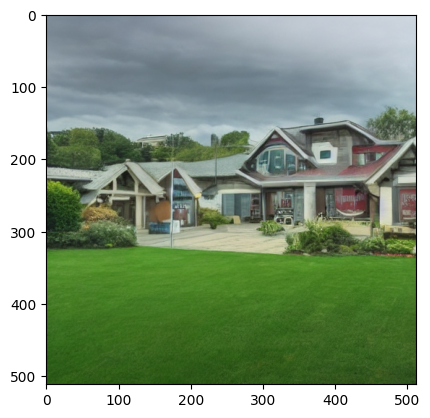

In [34]:

# Patch scheduler
pipe.scheduler = patch_ddim_with_classifier_guidance(
    pipe.scheduler, classifier=classifier, scale=40.0, target_prob=1.0
)

# Now you can just call pipe(prompt)
image = pipe("a picture of a golf ball", num_inference_steps=50, guidance_scale=7.5).images[0]
plt.imshow(image)


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


✅ Loaded latent classifier for 'airliner' (epoch 3)


Generating airliner images:   0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_2917534/1186396720.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(timestep, device=sample.device).expand(sample.shape[0])
Generating airliner images: 100%|██████████| 24/24 [01:21<00:00,  3.41s/it]


✅ Generation complete!


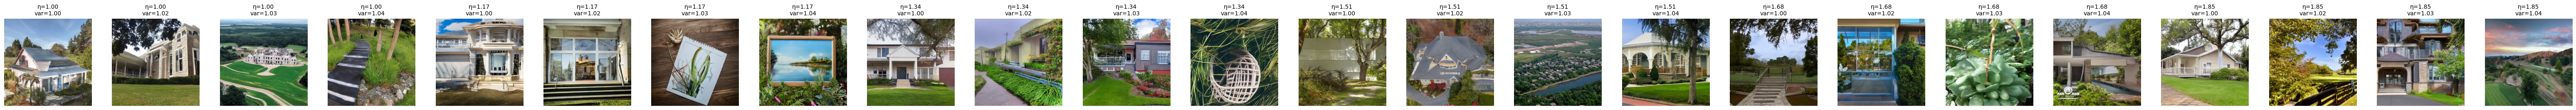

In [45]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn.functional as F
import types
from diffusers import StableDiffusionPipeline
import sys
sys.path.append("/share/u/kevin/DiffusionConceptErasure/src/")

from noisy_diffuser_scheduling.schedulers.eta_ddim_scheduler import DDIMScheduler
from create_latent_classifier import LatentClassifierT


# ============================================================
# 1️⃣ Config
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
concept = "airliner"

etas = [1.0, 1.17, 1.34, 1.51, 1.68, 1.85]
variance_scales = [1.0, 1.02, 1.03, 1.04]
classifier_scales = [30]
prompt = "a picture of a golf ball"

out_dir = f"results/{concept}_eta_var_sweep"
os.makedirs(out_dir, exist_ok=True)


import torch, os
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DDIMScheduler
from create_latent_classifier import LatentClassifierT

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load Stable Diffusion ---
# model_path = "kevinlu4588/esd-x-airliner"
model_path = "/share/u/kevin/ErasingDiffusionModels/final_models/esdx_golf_ball"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to(device)
pipe.scheduler = DDIMScheduler.from_pretrained(model_path, subfolder="scheduler", torch_dtype=torch.float16)
pipe.safety_checker = None

# --- Load classifier ---
classifier_path = "/share/u/kevin/DiffusionConceptErasure/classifier_guidance/latent_classifiers/golf_ball.pt"

classifier = LatentClassifierT(scheduler=pipe.scheduler).to(device)
checkpoint = torch.load(classifier_path, map_location=device)
classifier.load_state_dict(checkpoint["model_state_dict"])
classifier.eval()
print(f"✅ Loaded latent classifier for 'airliner' (epoch {checkpoint.get('epoch', '?')})")

# ============================================================
# 3️⃣ Monkey patch function
# ============================================================
def patch_ddim_with_classifier_guidance(scheduler, classifier, scale=30.0, target_prob=1.0):
    orig_step = scheduler.__class__.step

    def step_with_classifier(self, model_output, timestep, sample, *args, **kwargs):
        if self.config.prediction_type == "epsilon" and classifier is not None and scale > 0:
            sample_detached = sample.detach().clone().to(torch.float32).requires_grad_(True)
            t_tensor = torch.tensor(timestep, device=sample.device).expand(sample.shape[0])
            with torch.enable_grad():
                logits = classifier(sample_detached, t_tensor)
                target = torch.full_like(logits.squeeze(), fill_value=target_prob)
                loss = F.binary_cross_entropy_with_logits(logits.squeeze(), target)
                grad = torch.autograd.grad(-loss, sample_detached, retain_graph=False)[0]
            grad = grad.to(sample.dtype)

            # ensure on same device
            self.alphas_cumprod = self.alphas_cumprod.to(sample.device)
            alpha_prod_t = self.alphas_cumprod[timestep]
            beta_prod_t = 1 - alpha_prod_t
            model_output = model_output - beta_prod_t.sqrt() * scale * grad

        return orig_step(self, model_output, timestep, sample, *args, **kwargs)

    scheduler.step = types.MethodType(step_with_classifier, scheduler)
    return scheduler


# ============================================================
# 4️⃣ Sweep & generate
# ============================================================
all_images = []
col_labels = []

combinations = [(eta, vs) for eta in etas for vs in variance_scales]
n_rows, n_cols = len(classifier_scales), len(combinations)

with tqdm(total=len(combinations) * len(classifier_scales), desc=f"Generating {concept} images") as pbar:
    for cls_scale in classifier_scales:
        row_imgs = []
        # patch scheduler with the given classifier strength
        pipe.scheduler = patch_ddim_with_classifier_guidance(pipe.scheduler, classifier=classifier, scale=cls_scale)

        for (eta, var_scale) in combinations:
            image = pipe(
                prompt,
                num_inference_steps=50,
                guidance_scale=7.5,
                eta=eta,
                variance_scale=var_scale,
            ).images[0]

            # save and track
            filename = f"{concept}_cls{cls_scale}_eta{eta:.2f}_var{var_scale:.2f}.png"
            image.save(os.path.join(out_dir, filename))
            row_imgs.append(image)

            if cls_scale == classifier_scales[0]:
                col_labels.append(f"η={eta:.2f}\nvar={var_scale:.2f}")

            pbar.update(1)

        all_images.append(row_imgs)

print("✅ Generation complete!")


# ============================================================
# 5️⃣ Plot grid
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.6 * n_cols, 2.6 * n_rows))

for i, cls_scale in enumerate(classifier_scales):
    for j, (eta, var_scale) in enumerate(combinations):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        ax.imshow(all_images[i][j])
        ax.axis("off")

        if i == 0:
            ax.set_title(col_labels[j], fontsize=10)
        if j == 0:
            ax.set_ylabel(f"clf={cls_scale}", fontsize=10, rotation=0, labelpad=45, va="center")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, f"{concept}_grid.png"), dpi=150)
plt.show()


In [37]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

def get_topk_images_by_clip_score(
    images, prompt, k=5, model=None, processor=None, device=None, batch_size=8, show=True
):
    """
    Given a list of images and a text prompt, returns and optionally displays the top-k images
    ranked by CLIP similarity to the prompt.

    Args:
        images (list[PIL.Image|str]): list of PIL images or file paths.
        prompt (str): text prompt for CLIP scoring.
        k (int): number of top images to return/display.
        model, processor: optional preloaded CLIP model and processor.
        device: optional device string.
        batch_size (int): batch size for encoding images.
        show (bool): whether to display a matplotlib grid.

    Returns:
        top_images (list[PIL.Image.Image])
        top_logits (list[float])
        all_logits (list[float])
    """

    # Setup device and load CLIP model
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    if model is None or processor is None:
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Ensure all inputs are RGB PIL images
    pil_images = [Image.open(img).convert("RGB") if isinstance(img, str) else img.convert("RGB") for img in images]

    # Encode text once
    text_inputs = processor(text=[prompt], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Encode all images in batches
    image_features_all = []
    for i in range(0, len(pil_images), batch_size):
        batch = pil_images[i:i + batch_size]
        image_inputs = processor(images=batch, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            feats = model.get_image_features(**image_inputs)
            feats /= feats.norm(dim=-1, keepdim=True)
        image_features_all.append(feats)
    image_features_all = torch.cat(image_features_all, dim=0)

    # Compute raw similarity logits (unnormalized cosine * scale)
    # Equivalent to logits_per_image in CLIP forward pass
    clip_logits = (image_features_all @ text_features.T).squeeze() * model.logit_scale.exp()

    # Rank and select top-k
    topk_vals, topk_idx = clip_logits.topk(k)
    topk_idx = topk_idx.cpu().tolist()
    topk_vals = topk_vals.cpu().tolist()

    top_images = [pil_images[i] for i in topk_idx]

    # Optionally show results
    if show:
        fig, axes = plt.subplots(1, k, figsize=(3*k, 3))
        for i in range(k):
            ax = axes[i]
            ax.imshow(top_images[i])
            ax.axis("off")
            ax.set_title(f"{i+1}: {topk_vals[i]:.3f}", fontsize=10)
        plt.suptitle(f"Top-{k} CLIP matches for: '{prompt}'", fontsize=14)
        plt.tight_layout()
        plt.show()

    return top_images, topk_vals, clip_logits.cpu().tolist()


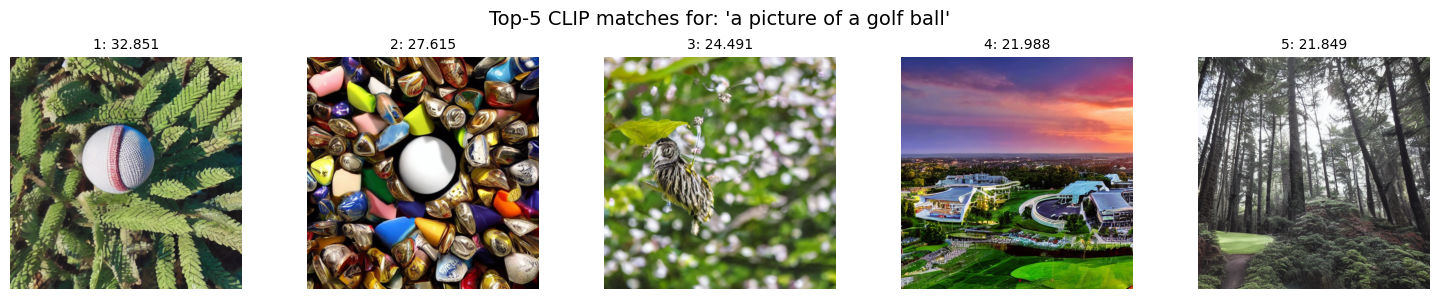

In [38]:
flat_images = [img for row in all_images for img in row]  # flatten your sweep grid
top_images, top_logits, all_logits = get_topk_images_by_clip_score(flat_images, prompt, k=5)
